In [9]:
from datasets import load_from_disk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as transforms
from transformers import DeiTModel, Trainer, TrainingArguments
from sklearn.metrics import roc_auc_score, f1_score, multilabel_confusion_matrix, accuracy_score
import random
from utils import compute_all_metrics_with_ci

In [10]:
train_dataset = load_from_disk("nlmcxr_labeled_train")
test_dataset = load_from_disk("nlmcxr_labeled_test")

In [11]:
MEAN_RGB = [0.485, 0.456, 0.406]
STDDEV_RGB = [0.229, 0.224, 0.225]

image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN_RGB, std=STDDEV_RGB)
])

sample_image = train_dataset[0]["image"]
transformed_image = image_transform(sample_image)
print(transformed_image.shape)

torch.Size([3, 224, 224])


In [12]:
class NLMCXRDataset(Dataset):
    def __init__(self, dataset, image_transform=None):
        self.dataset = dataset
        self.image_transform = image_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]

        # Process image
        image = sample["image"]
        if self.image_transform:
            image = self.image_transform(image)
            # Manually clamp the tensor values to be between [0, 1]
            image = torch.clamp(image, min=0.0, max=1.0)

        # Process label
        label_vector = torch.tensor(sample['label_vector'], dtype=torch.float32)

        # Process binary label
        binary_label = torch.tensor(sample['binary_label'], dtype=torch.float32).unsqueeze(0)

        return {
            "image": image,
            "label_vector": label_vector,
            "binary_label": binary_label
        }

# Create dataset objects
train_dataset_pytorch = NLMCXRDataset(train_dataset, image_transform)
test_dataset_pytorch = NLMCXRDataset(test_dataset, image_transform)

# Example: Load a sample
sample = train_dataset_pytorch[0]
print("Image Shape:", sample["image"].shape)  # (3, 224, 224)
print(sample["image"].min(), sample["image"].max())  # tensor(0.0000) tensor(1.0000)
print("Label Vector Shape:", sample["label_vector"].shape)  # (14,)
print("Binary Label Shape:", sample["binary_label"].shape)  # (1,)

Image Shape: torch.Size([3, 224, 224])
tensor(0.) tensor(1.)
Label Vector Shape: torch.Size([14])
Binary Label Shape: torch.Size([1])


In [13]:
train_subset = Subset(train_dataset_pytorch, random.sample(range(len(train_dataset_pytorch)), 240))
val_subset = Subset(train_dataset_pytorch, random.sample(range(len(train_dataset_pytorch)), 30))
test_subset = Subset(test_dataset_pytorch, random.sample(range(len(test_dataset_pytorch)), 30))

In [14]:
class MultiLabelDeiTModel(nn.Module):
    def __init__(self, num_labels):
        super(MultiLabelDeiTModel, self).__init__()

        self.deit = DeiTModel.from_pretrained("facebook/deit-tiny-patch16-224")
        # self.deit = AutoModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")

        # Freeze the DeiT model parameters
        for param in self.deit.parameters():
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(self.deit.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.1), # It was 0.001? 
            nn.Linear(512, num_labels)
        )

    def forward(self, image, label_vector):
        outputs = self.deit(pixel_values=image)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(pooled_output)

        if label_vector is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, label_vector)
            return loss, logits

        return logits

In [15]:
model_deit = MultiLabelDeiTModel(num_labels=14)

# Training setup
training_args = TrainingArguments(
    output_dir='./results_deit',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    learning_rate=5e-2,
    warmup_steps=200,
    lr_scheduler_type='cosine',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_strategy="epoch",
    weight_decay=1e-4,
    logging_dir="./logs",
    logging_steps=10
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.sigmoid(torch.tensor(logits)) > 0.5
    # accuracy = (preds == torch.tensor(labels)).float().mean().item()
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='micro')
    auc_roc = roc_auc_score(labels, preds, average='micro')
    return {"accuracy": accuracy, "f1": f1, "auc-roc":auc_roc}

trainer = Trainer(
    model=model_deit,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_subset,
    eval_dataset=val_subset
)

You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized: ['embeddings.cls_token', 'embeddings.distillation_token', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings', 'encoder.layer.0.attention.attention.key.bias', 'encoder.layer.0.attention.attention.key.weight', 'encoder.layer.0.attention.attention.query.bias', 'encoder.layer.0.attention.attention.query.weight', 'encoder.layer.0.attention.attention.value.bias', 'encoder.layer.0.attention.attention.value.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.layernorm_after.bias', 'enc

In [16]:
trainer.train()
print('Training complete.')

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc-roc
1,0.323000,0.314873,0.233333,0.208955,0.564568
2,0.305700,0.305533,0.000000,0.000000,0.500000
3,0.289800,0.281856,0.000000,0.000000,0.500000
4,0.287900,0.275390,0.000000,0.000000,0.500000
5,0.290300,0.309793,0.000000,0.000000,0.500000
6,0.286300,0.286551,0.033333,0.051282,0.512208
7,0.292900,0.300190,0.000000,0.000000,0.498695
8,0.308000,0.275856,0.000000,0.000000,0.500000
9,0.285100,0.273503,0.000000,0.000000,0.500000
10,0.258100,0.268507,0.000000,0.000000,0.500000


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: '

Training complete.


In [17]:
torch.save(model_deit.state_dict(), "deit_chest_model.pth")

In [18]:
# Save the model
trainer.save_model()

# Evaluate
trainer.evaluate()

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.31487342715263367,
 'eval_accuracy': 0.23333333333333334,
 'eval_f1': 0.208955223880597,
 'eval_auc-roc': 0.5645684849340202,
 'eval_runtime': 1.0977,
 'eval_samples_per_second': 27.329,
 'eval_steps_per_second': 3.644,
 'epoch': 10.0}

In [19]:
model_deit.load_state_dict(torch.load("deit_chest_model.pth"))

<All keys matched successfully>

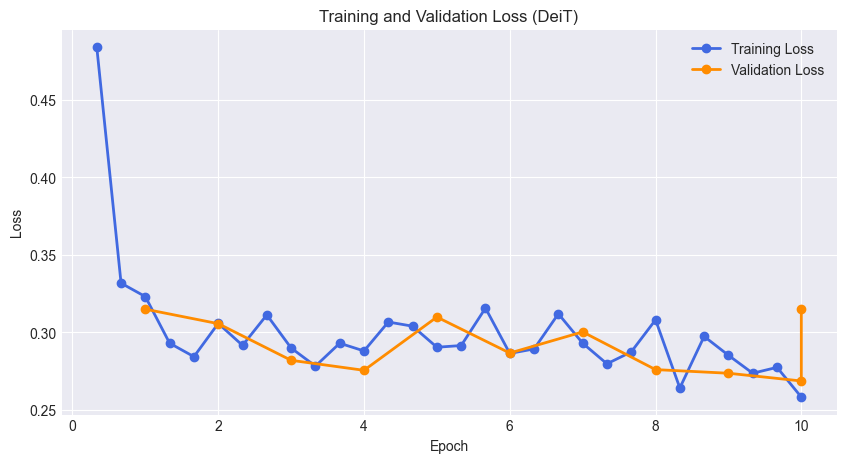

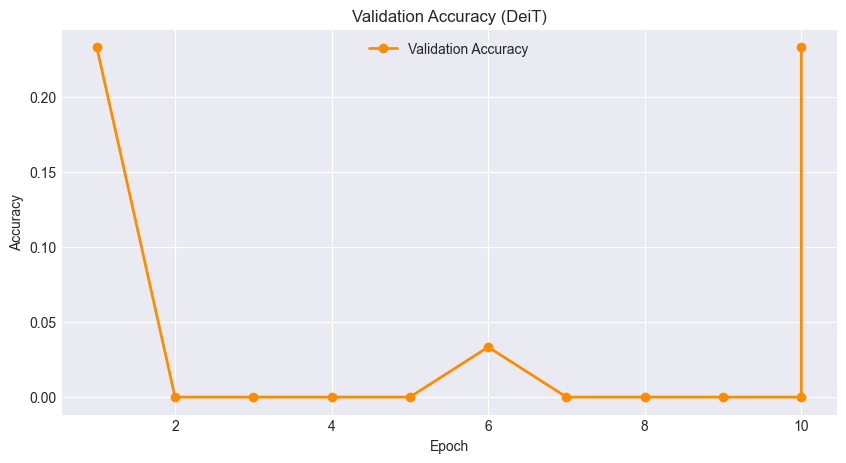

In [20]:
# Extract logs
logs = trainer.state.log_history

train_loss = []
eval_loss = []
eval_accuracy = []
train_epochs = []
eval_epochs = []

for log in logs:
    if "loss" in log and "epoch" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])  # store matching epoch
    if "eval_accuracy" in log:
        eval_accuracy.append(log["eval_accuracy"])

plt.style.use('seaborn-v0_8-darkgrid')
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_loss, label="Training Loss", marker='o', linewidth=2, color='royalblue')
plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker='o', linewidth=2, color='darkorange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (DeiT)")
plt.legend()
plt.grid(True)
plt.savefig("deit_chest_loss.png")
plt.show()

# Plot Accuracy (optional, if accuracy was computed)
if eval_accuracy:
    plt.figure(figsize=(10, 5))
    plt.plot(eval_epochs[:len(eval_accuracy)], eval_accuracy, label="Validation Accuracy", marker='o', linewidth=2, color='darkorange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy (DeiT)")
    plt.legend()
    plt.grid(True)
    plt.savefig("deit_chest_accuracy.png")
    plt.show()

In [21]:
# Use the Trainer's predict method on the test dataset
predictions = trainer.predict(test_subset)

# Extract logits and labels
logits = predictions.predictions
all_labels = predictions.label_ids

# Convert logits to binary predictions
binary_preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()

print("All Labels Shape:", all_labels.shape)
print("Binary Predictions Shape:", binary_preds.shape)

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


All Labels Shape: (30, 14)
Binary Predictions Shape: (30, 14)


In [22]:
y_true = all_labels
y_pred = binary_preds
y_pred_probs = torch.sigmoid(torch.tensor(logits)).numpy()

results = compute_all_metrics_with_ci(y_true, y_pred, y_prob=y_pred_probs, multilabel=True)

for metric, (mean_val, (low, high)) in results.items():
    if mean_val is not None:
        print(f"{metric}: {mean_val:.3f} (90% CI: {low:.3f} - {high:.3f})")
    else:
        print(f"{metric}: Not available")

accuracy: 0.528 (90% CI: 0.367 - 0.667)
f1: 0.483 (90% CI: 0.338 - 0.635)
auroc: 0.776 (90% CI: 0.698 - 0.851)
mcc: 0.441 (90% CI: 0.273 - 0.617)
brier: 0.066 (90% CI: 0.050 - 0.083)
sensitivity: 0.071 (90% CI: 0.071 - 0.071)
specificity: 0.929 (90% CI: 0.929 - 0.929)
balanced_accuracy: 0.500 (90% CI: 0.500 - 0.500)


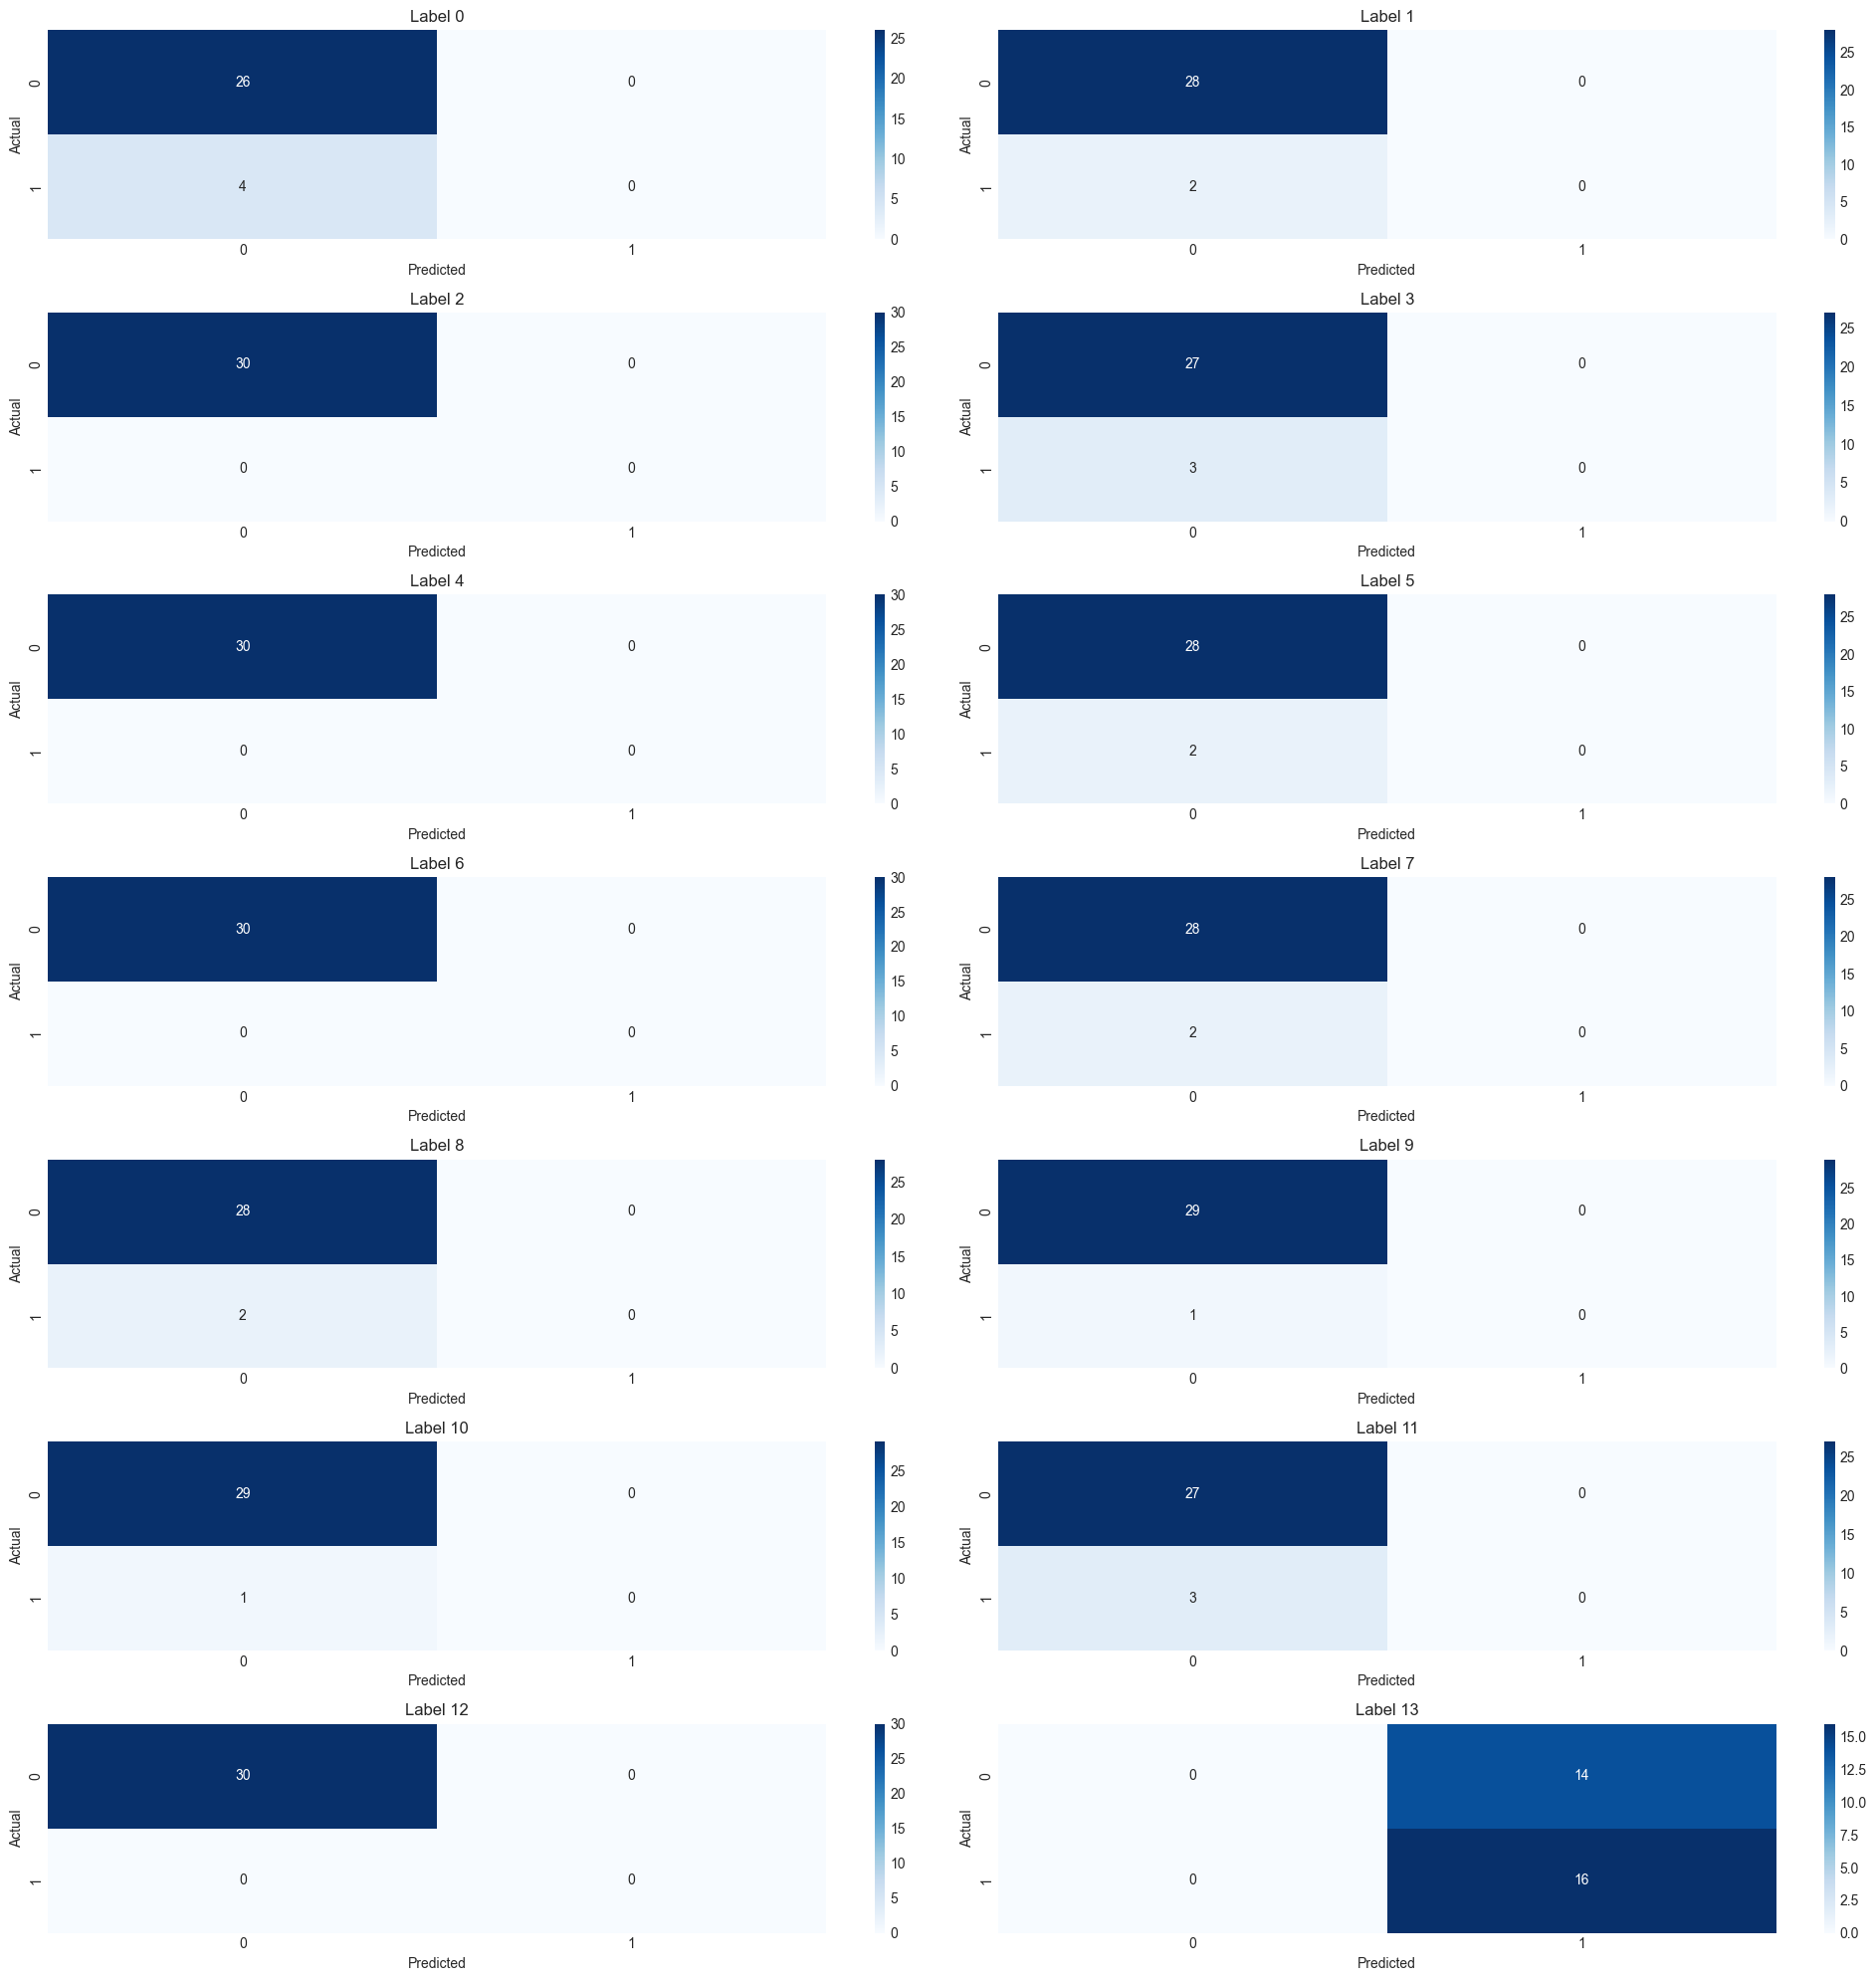

In [23]:
# Assuming `all_labels` and `binary_preds` are available from the evaluation function
# Compute the multilabel confusion matrix
confusion_matrices = multilabel_confusion_matrix(all_labels, binary_preds)

# Plot each confusion matrix
num_labels = confusion_matrices.shape[0]
fig, axes = plt.subplots(7, 2, figsize=(20, 20))

axes = axes.flatten()

for i, ax in enumerate(axes):
    cm = confusion_matrices[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Label {i}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.savefig("deit_chest_confusion_matrices.png")
plt.show()

In [24]:
class_names = [
    "Atelectasis",
    "Consolidation",
    "Infiltration",
    "Pneumothorax",
    "Edema",
    "Emphysema",
    "Fibrosis",
    "Effusion",
    "Pneumonia",
    "Pleural_thickening",
    "Cardiomegaly",
    "Nodule Mass",
    "Hernia",
    "No Finding"
]

print("Class Names:", class_names)

Class Names: ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_thickening', 'Cardiomegaly', 'Nodule Mass', 'Hernia', 'No Finding']


In [25]:
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    brier_score_loss
)

def compute_additional_metrics(labels, preds):
    
    metrics = {
        "micro_f1": f1_score(labels, preds, average="micro"),
        "macro_f1": f1_score(labels, preds, average="macro"),
        "roc_auc_micro": roc_auc_score(labels, preds, average="micro"),
        "matthews_corrcoef_micro": matthews_corrcoef(labels.flatten(), preds.flatten()),
    }

    # Compute brier score for each class
    brier_scores = []
    for i in range(labels.shape[1]):
        brier_scores.append(brier_score_loss(labels[:, i], preds[:, i]))
    
    metrics["brier_score_avg"] = sum(brier_scores) / len(brier_scores)

    sensitivities = []
    specificities = []
    balanced_accuracies = []

    for cm in confusion_matrices:
        TN, FP, FN, TP = cm.ravel()

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        balanced_accuracy = (sensitivity + specificity) / 2

        sensitivities.append(sensitivity)
        specificities.append(specificity)
        balanced_accuracies.append(balanced_accuracy)

    metrics["sensitivity_avg"] = sum(sensitivities) / len(sensitivities)
    metrics["specificity_avg"] = sum(specificities) / len(specificities)
    metrics["balanced_accuracy_avg"] = sum(balanced_accuracies) / len(balanced_accuracies)

    return metrics


In [26]:
metrics = compute_additional_metrics(all_labels, binary_preds)

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
# Print the metrics
print("Micro F1 Score:", metrics["micro_f1"])
print("ROC AUC Score (Micro):", metrics["roc_auc_micro"])
print("Matthews Correlation Coefficient (Micro):", metrics["matthews_corrcoef_micro"])
print("Brier Score (Average):", metrics["brier_score_avg"])
print("Sensitivity (Average):", metrics["sensitivity_avg"])
print("Specificity (Average):", metrics["specificity_avg"])
print("Balanced Accuracy (Average):", metrics["balanced_accuracy_avg"])


Micro F1 Score: 0.48484848484848486
ROC AUC Score (Micro): 0.7039930555555556
Matthews Correlation Coefficient (Micro): 0.4434751717066333
Brier Score (Average): 0.08095238095238096
Sensitivity (Average): 0.07142857142857142
Specificity (Average): 0.9285714285714286
Balanced Accuracy (Average): 0.5


In [28]:
sample_idx = 10  # Change this to view a different sample
print(f"Confidence scores for test sample {sample_idx}:")
print("Per-class confidence scores:", y_pred_probs[sample_idx])
print("Predicted labels:", y_pred[sample_idx])
print("Ground truth labels:", y_true[sample_idx])

Confidence scores for test sample 10:
Per-class confidence scores: [8.7071255e-02 5.0559675e-04 2.9271006e-05 5.0899237e-02 3.8364373e-02
 1.6608039e-02 6.3045859e-02 2.5903884e-01 1.9078065e-01 5.6010770e-04
 5.6370586e-02 8.4839992e-02 1.3809781e-02 5.7726425e-01]
Predicted labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Ground truth labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
